The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

- Record any observed trends in the data
- Produce a trained model to predict future sales numbers

Try your best to tune your model. It can be difficult, but don't worry - timeseries analysis is just a difficult and specialized topic.


- Assemble observations and graphs as well as timeseries models in a notebook.

In [1]:
#### Starter code

import pandas as pd
import numpy as np


%matplotlib inline
# get the Datas
data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [2]:
import datetime

#### Deliverable

**Look back at the readme from wednesday's lecture on timeseries for good information about these models and acf/pacf plots!**

1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per week.
- Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?
- Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and create an autocorrelation and partial autocorrelation plot.
- "Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)
- Split the weekly sales data in a training and test set - using 75% of the data for training.
- Create an AR(1) model on the training data and compute the mean absolute error of the predictions. How effective is this model?
- Plot the residuals - where are their significant errors?
- Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?
- Compute and ARIMA model

#### Additional Resources

1. [ARMA Example](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/tsa_arma.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

### 1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [7]:
store1 = data.loc[data['Store'] == 1]
store1.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [16]:
weekly_sales = pd.DataFrame(store1.groupby(store1.index).Weekly_Sales.sum())
weekly_sales.head()


,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


### 2. Plot the rolling_mean for Weekly_Sales. What general trends do you observe?

In [21]:
# resetting the index to make Date a datetime object
weekly_sales.reset_index(inplace=True)

weekly_sales['Date'] = pd.to_datetime(weekly_sales['Date'])

# making date index once again
weekly_sales.set_index('Date', inplace=True)

weekly_sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=1,center=False).mean()
  
/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=4,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/elutins/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=13,center=False).mean()
  after removing the cwd from sys.path.


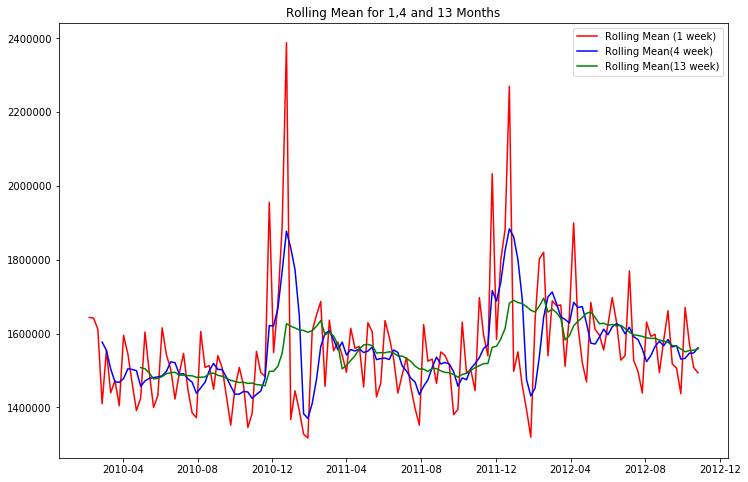

In [25]:
# Plotting the Rolling Mean
rolmean1 = pd.rolling_mean(weekly_sales, window = 1)
rolmean4 = pd.rolling_mean(weekly_sales, window = 4)
rolmean13 = pd.rolling_mean(weekly_sales, window = 13)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
plt.plot(rolmean1, color='red', label='Rolling Mean (1 week)')
plt.plot(rolmean4, color='blue', label='Rolling Mean(4 week)')
plt.plot(rolmean13, color='green', label='Rolling Mean(13 week)')

plt.legend(loc='best')
plt.title('Rolling Mean for 1,4 and 13 Months')
plt.show()

In [ ]:
# There appears to be a very large spike around the same time every year. 

### 3. Compute the 1, 2, 52 autocorrelations for Weekly_Sales and create an autocorrelation and partial autocorrelation plot.

In [27]:
print '1 Week Lag AutoCorr', weekly_sales['Weekly_Sales'].autocorr(lag=1)
print '2 Week Lag AutoCorr', weekly_sales['Weekly_Sales'].autocorr(lag=2)
print '52 Week Lag AutoCorr', weekly_sales['Weekly_Sales'].autocorr(lag=52)

1 Week Lag AutoCorr 0.302158279411
2 Week Lag AutoCorr 0.127413130554
52 Week Lag AutoCorr 0.895376029478


#####  We can tell by the above numbers that there is the highest correlation between 52 weeks, signalling a strong annual correlation in sales

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/elutins/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [31]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

In [33]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

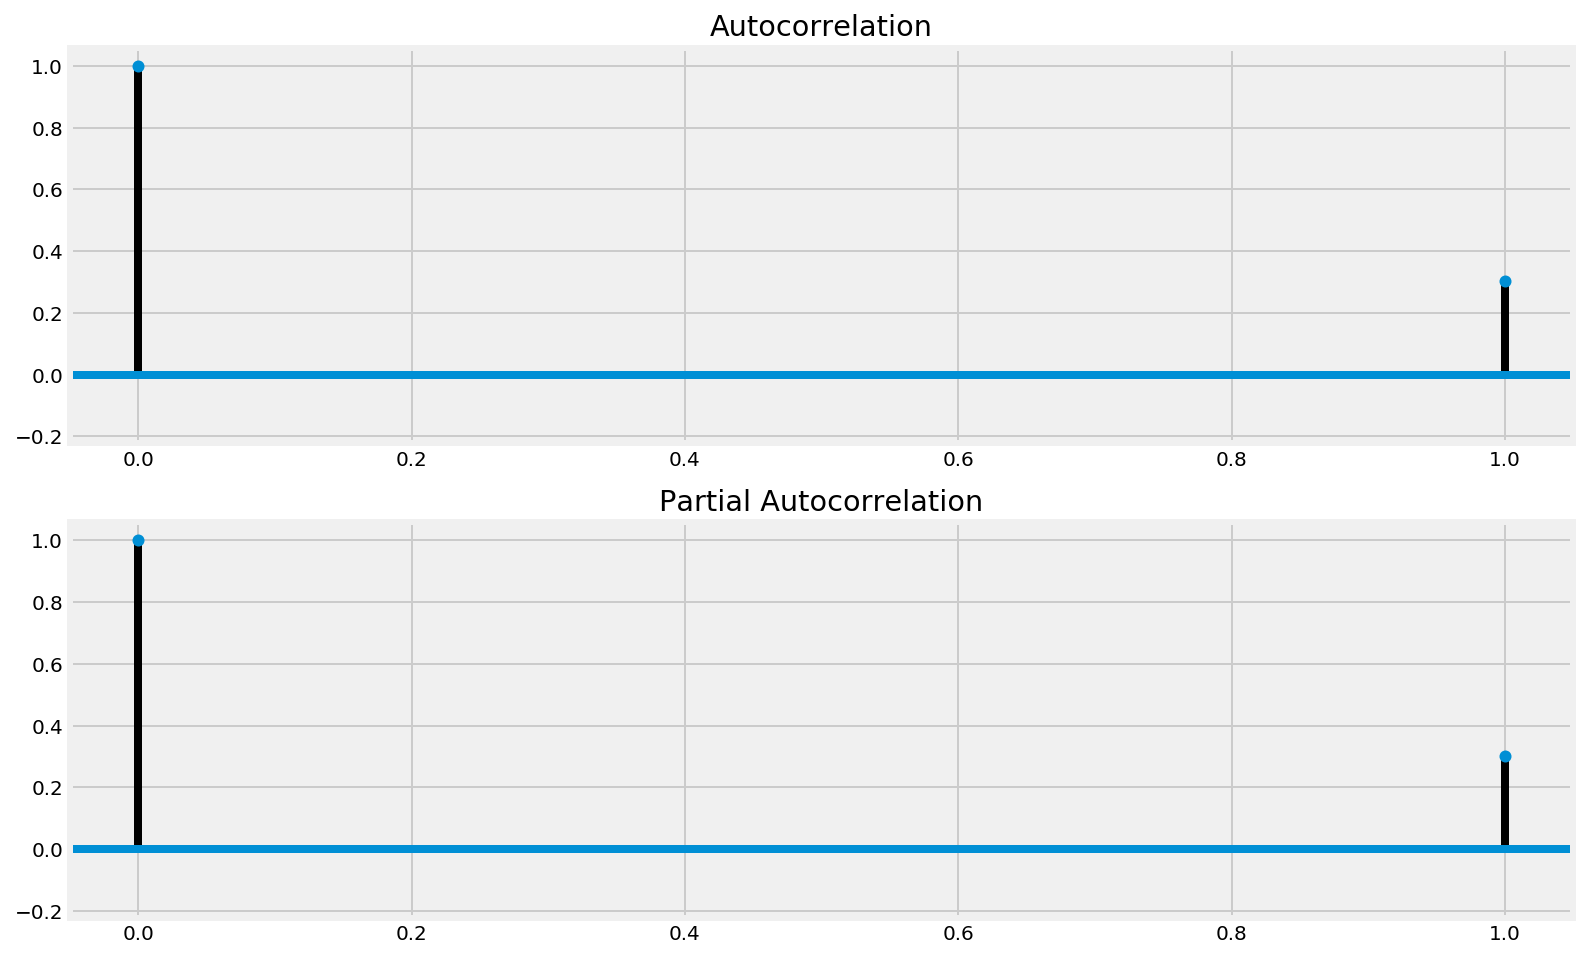

In [34]:
# Partial and Autocorrelation for 1 Week Lag
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(weekly_sales['Weekly_Sales'], lags=1, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weekly_sales['Weekly_Sales'], lags=1, ax=ax2)

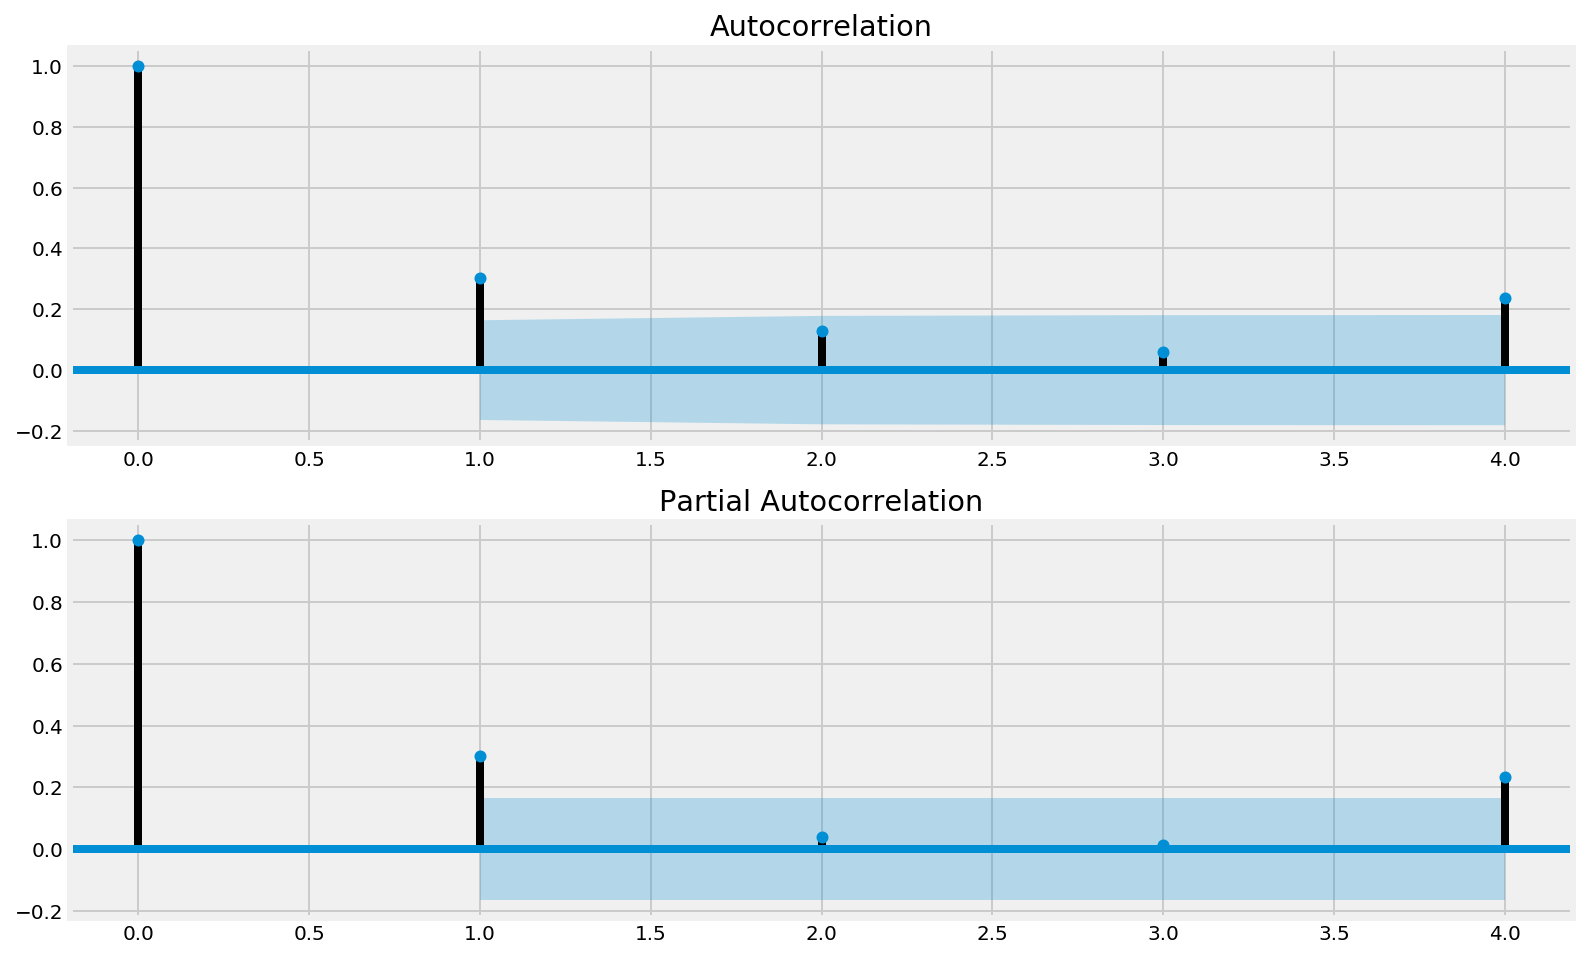

In [35]:
# Partial and Autocorrelation for 4 Week Lag
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(weekly_sales['Weekly_Sales'], lags=4, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weekly_sales['Weekly_Sales'], lags=4, ax=ax2)

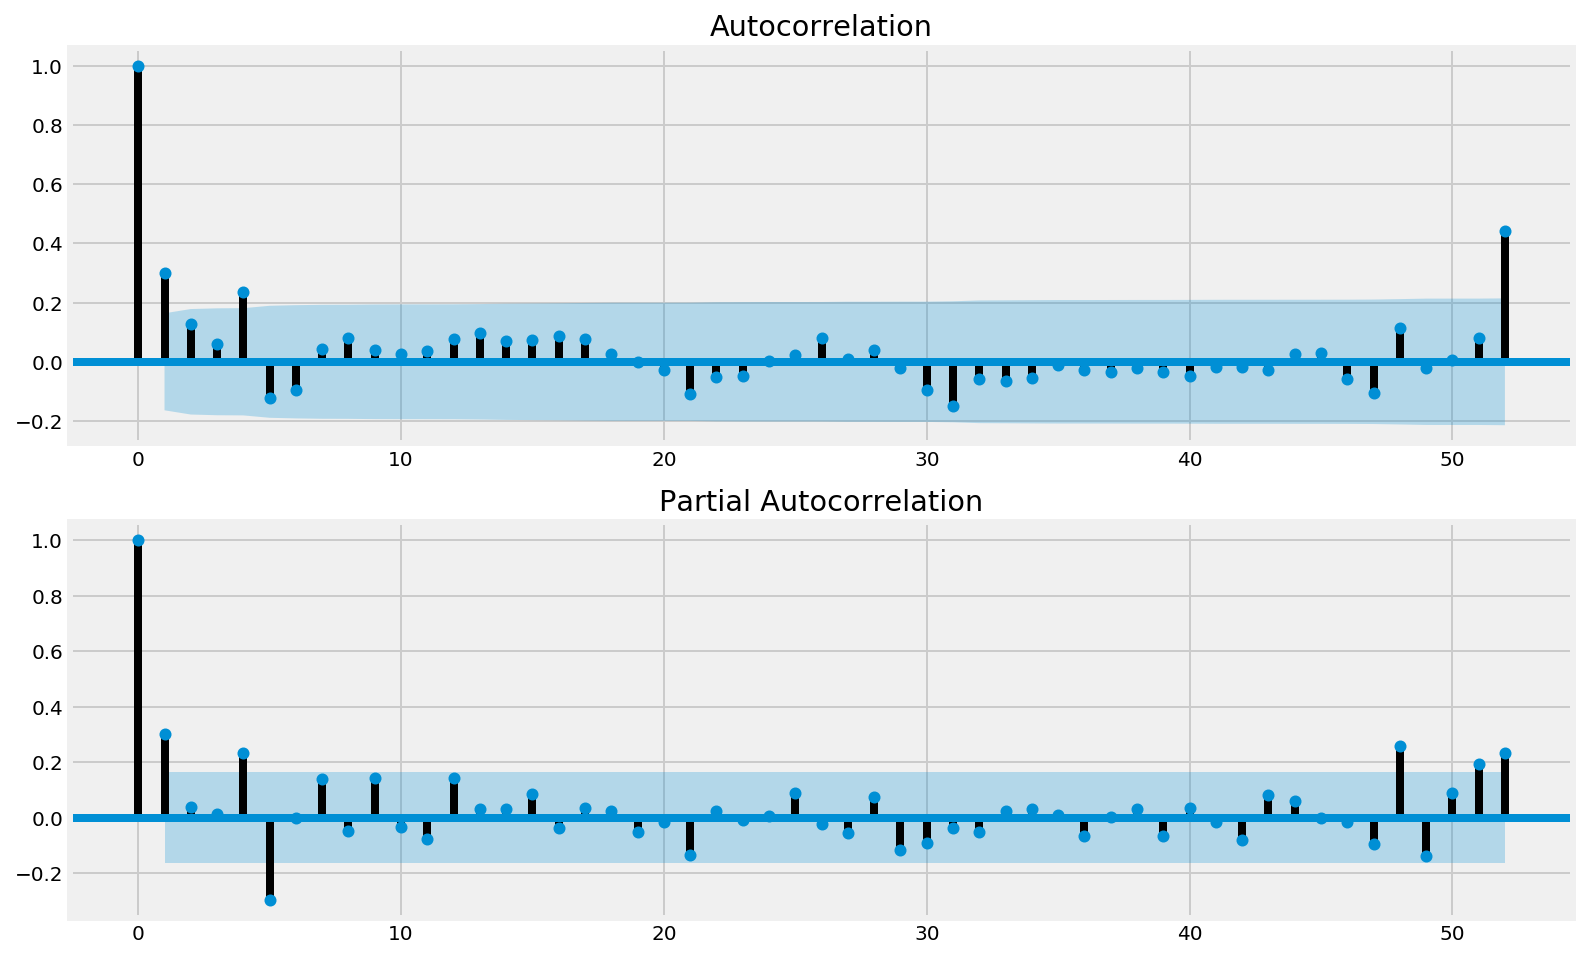

In [36]:
# Partial and Autocorrelation for 52 Week Lag
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(weekly_sales['Weekly_Sales'], lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weekly_sales['Weekly_Sales'], lags=52, ax=ax2)


### 4. Split the weekly sales data in a training and test set - using 75% of the data for training.

In [38]:
weekly_sales.shape

(143, 1)

In [39]:
# Since the dataframe contains 143 observations, 143*.75 will be used for training purposes  
143*0.75

107.25

In [40]:
train = weekly_sales.iloc[:108]
test = weekly_sales.iloc[108:]

### 5. "Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)

```python
series.diff(periods = n)
```

In [44]:
train.diff(periods = 1)

,Weekly_Sales
Date,
2010-02-05,NaN
2010-02-12,-1733.46
2010-02-19,-29989.27
2010-02-26,-202240.58
2010-03-05,145079.09
2010-03-12,-115265.09
2010-03-19,32974.20
2010-03-26,-68085.87
2010-04-02,190538.36


### 6.Create an AR(1) model on the training data and compute the mean absolute error of the predictions. 
####    How effective is this model?

In [45]:
from statsmodels.tsa.arima_model import AR, ARMA, ARIMA

train_values = train['Weekly_Sales'].values
train_dates = train.index


AR1 = AR(train_values, train_dates).fit()

In [50]:
test.tail(6)

,Weekly_Sales
Date,
2012-09-21,1506126.06
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81
2012-10-19,1508068.77
2012-10-26,1493659.74


In [51]:
test_values = test['Weekly_Sales'].values
test_dates = test.index

# The AR Predict takes a start and and end date as values and not a list.
start = '2012-02-24'
end = '2012-10-19'


AR1_pred = AR1.predict(start=start, end = end)

In [52]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_values, AR1_pred)

77317.669852138017

### 7. Plot the residuals - where are their significant errors?

In [53]:
AR1_residuals = test_values - AR1_pred

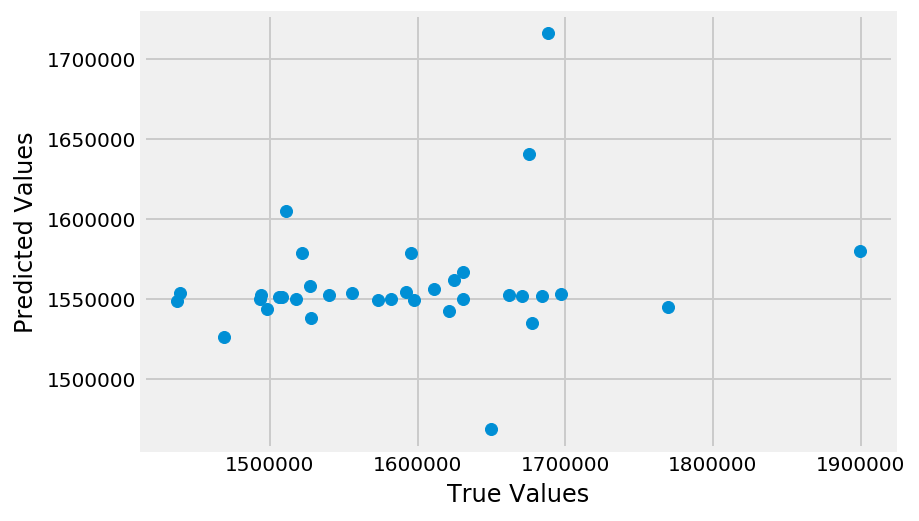

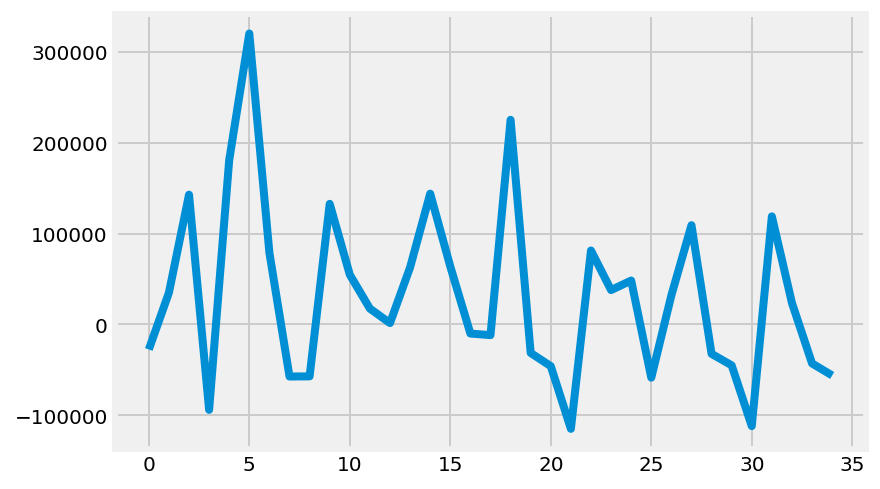

In [54]:
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.scatter(test_values, AR1_pred)
plt.show()

plt.plot(AR1_residuals)
plt.show()

### 8. Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?

In [55]:
AR2 = ARMA(endog = train_values, dates = train_dates, order = (2,0)).fit()

# Same start and end we outlined earlier.
AR2_pred = AR2.predict(start=start, end = end)

mean_absolute_error(test_values, AR2_pred)
# does not help abs mean score

79528.988646579688

In [56]:
AR2_2 = ARMA(endog = train_values, dates = train_dates, order = (2,2)).fit()

# Same start and end we outlined earlier.
AR2_2_pred = AR2_2.predict(start=start, end = end)

mean_absolute_error(test_values, AR2_2_pred)
# does not help either

83531.62747827117

### 9. Create an ARIMA Model with the data. Assess its performance

In [57]:
model = ARIMA(endog = train_values, dates = train_dates, order=(1,1,2)).fit()
model_pred = model.predict(start=start, end = end)
model.summary()

/Users/elutins/anaconda/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/elutins/anaconda/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/elutins/anaconda/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/elutins/anaconda/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: invalid value encountered in divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/elutins/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/elutins/anaconda

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  107
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1435.463
Method:                       css-mle   S.D. of innovations         159178.405
Date:                Sun, 03 Sep 2017   AIC                           2880.926
Time:                        13:02:33   BIC                           2894.290
Sample:                    02-12-2010   HQIC                          2886.343
                         - 02-24-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1109.9022    705.477      1.573      0.119    -272.807    2492.611
ar.L1.D.y      0.3973      0.315      1.263      0.210      -0.219       1.014
ma.L1.D.y     -1.1227      0.338     -3.321      0.001      -1.785      -0.460
ma.L2.D.y      0.1227      0.337      0.364      0.717      -0.538       0.783
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5173           +0.0000j            2.5173            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            8.1528           +0.0000j            8.1528            0.0000
-----------------------------------------------------------------------------
"""

In [62]:
model = ARIMA(endog = train_values, dates = train_dates, order=(1,0,2)).fit()
model_pred = model.predict(start=start, end = end)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(1, 2)   Log Likelihood               -1447.577
Method:                       css-mle   S.D. of innovations         160182.715
Date:                Sun, 03 Sep 2017   AIC                           2905.154
Time:                        13:03:28   BIC                           2918.565
Sample:                    02-05-2010   HQIC                          2910.592
                         - 02-24-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   2.37e+04     65.134      0.000     1.5e+06    1.59e+06
ar.L1.y        0.4835      0.438      1.104      0.272      -0.375       1.342
ma.L1.y       -0.1940      0.455     -0.427      0.670      -1.085       0.697
ma.L2.y       -0.0076      0.140     -0.054      0.957      -0.283       0.267
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0682           +0.0000j            2.0682            0.0000
MA.1            4.3984           +0.0000j            4.3984            0.0000
MA.2          -29.9407           +0.0000j           29.9407            0.5000
-----------------------------------------------------------------------------
"""

#### Based on the two ARIMA models above, the first model has the lower AIC score and is therefore a more accurate model.